In [1]:
import numpy as np   
import pandas as pd  
import os
import gc
import seaborn as sns  # for plotting graphs
import matplotlib.pyplot as plt # for plotting graphs aswell
import glob
from datetime import datetime
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix, hstack
import lightgbm
from sklearn.model_selection import KFold

from lightgbm import LGBMClassifier
%matplotlib inline



/Users/israelphiri/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# to display maximum rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
# function to set all numerical data to int16 or float16, to save on memory use
def dtype_conver(Dataframe):
    for col in Dataframe:
        if Dataframe[col].dtype == 'float32' or 'float64':
            Dataframe[col] = Dataframe[col].astype(np.float16)
        if Dataframe[col].dtype == 'int8' or 'int32' or 'float64':
            Dataframe[col] = Dataframe[col].astype(np.int16)

In [4]:
# Read in filepath  
DATA_PATH = '/Users/israelphiri/Documents/home_site_insurance'
file_name = os.path.join(DATA_PATH,'train.csv')


In [5]:
# pandas reads in csv file using filepath
old_train_df = pd.read_csv(file_name)
print(old_train_df.shape)
#original_quote_date is time-series

(260753, 299)


In [6]:
#Feature Engineering
old_train_df['Original_Quote_Date'] = pd.to_datetime(old_train_df['Original_Quote_Date'])
old_train_df['year'] = old_train_df['Original_Quote_Date'].dt.year
old_train_df['month'] = old_train_df['Original_Quote_Date'].dt.month
old_train_df['day'] = old_train_df['Original_Quote_Date'].dt.day
train_df = old_train_df.drop(["Original_Quote_Date"], axis = 1)

In [7]:
# lets see how many NaN or Null values are in each column
nan_info = pd.DataFrame(train_df.isnull().sum()).reset_index()
nan_info.columns = ['col','nan_cnt']


In [8]:
#sort them in descending order and print 1st 10
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info.head(10)

col  nan_cnt
160     PropertyField29   200685
124     PersonalField84   124208
169     PropertyField38     1220
167     PropertyField36      113
48       PersonalField7      113
129      PropertyField3       81
163     PropertyField32       70
165     PropertyField34       70
130      PropertyField4       63
198  GeographicField14A        0

In [9]:
# extract column names with NaNs and Nulls
# in numerical cols
num_cols_with_missing = ['PersonalField84','PropertyField29']



In [10]:
# extract column names with NaNs and Nulls
# in boolean type cols
bool_cols_with_missing = ['PropertyField3','PropertyField4','PersonalField7','PropertyField32',
                          'PropertyField34','PropertyField36','PropertyField38']


In [11]:
# fill in null and NaN values with 'U' in boolean type cols ( 'Y','N')
for cols in bool_cols_with_missing:
    train_df[cols].fillna('U',inplace=True)



In [12]:
# fill in null and NaN values with -1 in numerical missing values
for cols in num_cols_with_missing:
    train_df[cols].fillna(-1, inplace=True)


In [13]:
# define target
y = old_train_df["QuoteConversion_Flag"].values

In [14]:
# drop target column from data
# and static columns GeographicField10A & PropertyField6
X = train_df.drop(["QuoteConversion_Flag","GeographicField10A","PropertyField6"], axis = 1)


In [ ]:
#drop geographic field 10A since it shows all the same value, could be identifying country
# property Field6 also all zeros we should drop also
#log of salesfield8 then hstack to bring back into sparse matrix

In [15]:
#QuoteNumber setting as index
X = X.set_index("QuoteNumber")

In [16]:
# select all columns that are categorical i.e with unique categories less than 40 in our case
X_for_ohe = [cols for cols in X.columns if X[cols].nunique() < 40 or X[cols].dtype in['object']]
X_not_ohe = [cols for cols in X.columns if X[cols].nunique() > 40 and X[cols].dtype not in['object']]


In [17]:
#numerical column that we will not encode
X[X_not_ohe].head()


SalesField8
QuoteNumber             
1                  48649
2                  26778
4                   8751
6                  43854
8                  12505

In [18]:
#to keep track of our columns, how many are remaining after we removed 4 so far?
len(X_for_ohe)

296

In [32]:
X['SalesField8']

QuoteNumber
1         2.378906
2         2.322266
4         2.205078
6         2.369141
8         2.244141
12        2.398438
13        2.263672
14        2.390625
18        2.152344
19        2.396484
20        2.400391
22        2.294922
25        2.367188
26        2.324219
28        2.253906
29        2.244141
30        2.398438
32        2.330078
35        2.373047
37        2.324219
38        2.277344
40        2.179688
41        2.216797
44        2.265625
45        2.402344
47        2.400391
50        2.398438
51        2.140625
53        2.214844
57        2.216797
59        2.154297
62        2.333984
64        2.394531
65        2.332031
66        2.371094
70        2.375000
71        2.388672
72        2.396484
73        2.261719
74        2.390625
76        2.005859
77        2.406250
78        2.367188
79        2.398438
80        2.388672
83        2.347656
84        2.341797
85        2.234375
86        1.993164
87        2.402344
88        2.234375
89        2.158203


In [19]:
nan_info = pd.DataFrame(X[X_for_ohe].isnull().sum()).reset_index()
nan_info.columns = ['col','nan_cnt']

In [20]:
#sort them in descending order and print 1st 10
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info.head(10)

col  nan_cnt
0                Field6        0
203  GeographicField19A        0
201  GeographicField18A        0
200  GeographicField17B        0
199  GeographicField17A        0
198  GeographicField16B        0
197  GeographicField16A        0
196  GeographicField15B        0
195  GeographicField15A        0
194  GeographicField14B        0

In [53]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories = 'auto',sparse=True)


In [54]:
# apply OneHotEncoder on categorical feature columns
X_ohe = ohe.fit_transform(X[X_for_ohe])


In [55]:
# we are pretty much done for now here, apparently we can set 'sparse = True' in OneHotEncoder and we get a 
#csr_matrix. I left it as false so that you can see the sparse matrix
X_ohe


<260753x5056 sparse matrix of type '<class 'numpy.float64'>'
	with 77182888 stored elements in Compressed Sparse Row format>

In [60]:
#SalesField8 was not kept out of sparse matrix, now we need to bring it back
# scaledown SalesField8 for easy handling using log(), then convert to float16
SF8 = np.log(X['SalesField8']).astype(np.float16)
#np.array(SF8)
#SF8.head()
#sparse.hstack((sp,np.array([7,7,7])[:,None]))
hstack((X_ohe,np.array(SF8)[:,None]))

/Users/israelphiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


<260753x5057 sparse matrix of type '<class 'numpy.float64'>'
	with 77443641 stored elements in COOrdinate format>

In [ ]:
#Need to add back in Salesfield8 USe Hstack, before that use log of Salesfield8

In [61]:
#Parameters for lightGBM classification
model_lgb = LGBMClassifier(
        n_jobs=4,
        n_estimators=100000,
        boost_from_average='false',
        learning_rate=0.02,
        num_leaves=64,
        num_threads=4,
        max_depth=7,
        tree_learner = "serial",
        feature_fraction = 0.7,
        bagging_freq = 5,
        bagging_fraction = 0.5,
#         min_data_in_leaf = 75,
#         min_sum_hessian_in_leaf = 50.0,
        silent=-1,
        verbose=-1,
        device='cpu',
        )

In [62]:
kf = KFold(n_splits=5, random_state=10, shuffle=True)

Fold :0
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.956349	training's binary_logloss: 0.23659	valid_1's auc: 0.954934	valid_1's binary_logloss: 0.236136
[200]	training's auc: 0.960346	training's binary_logloss: 0.190181	valid_1's auc: 0.958273	valid_1's binary_logloss: 0.190904
[300]	training's auc: 0.963806	training's binary_logloss: 0.177824	valid_1's auc: 0.960434	valid_1's binary_logloss: 0.180933
[400]	training's auc: 0.967169	training's binary_logloss: 0.170128	valid_1's auc: 0.961874	valid_1's binary_logloss: 0.176688
[500]	training's auc: 0.970022	training's binary_logloss: 0.163974	valid_1's auc: 0.962687	valid_1's binary_logloss: 0.17427
[600]	training's auc: 0.972354	training's binary_logloss: 0.159235	valid_1's auc: 0.96317	valid_1's binary_logloss: 0.173036
[700]	training's auc: 0.974473	training's binary_logloss: 0.155004	valid_1's auc: 0.963435	valid_1's binary_logloss: 0.172301
[800]	training's auc: 0.976326	training's binary_log

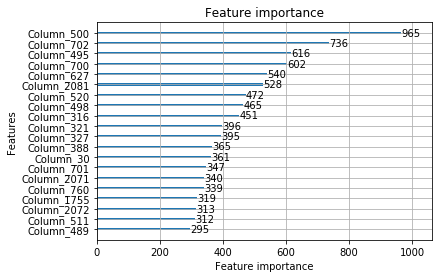

Fold :1
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.9566	training's binary_logloss: 0.237192	valid_1's auc: 0.954724	valid_1's binary_logloss: 0.240395
[200]	training's auc: 0.960164	training's binary_logloss: 0.189817	valid_1's auc: 0.957797	valid_1's binary_logloss: 0.194619
[300]	training's auc: 0.963734	training's binary_logloss: 0.177689	valid_1's auc: 0.960181	valid_1's binary_logloss: 0.184659
[400]	training's auc: 0.967156	training's binary_logloss: 0.169612	valid_1's auc: 0.961711	valid_1's binary_logloss: 0.179802
[500]	training's auc: 0.969896	training's binary_logloss: 0.164088	valid_1's auc: 0.96238	valid_1's binary_logloss: 0.17787
[600]	training's auc: 0.972318	training's binary_logloss: 0.158995	valid_1's auc: 0.962967	valid_1's binary_logloss: 0.176133
[700]	training's auc: 0.974348	training's binary_logloss: 0.154576	valid_1's auc: 0.963227	valid_1's binary_logloss: 0.175172
[800]	training's auc: 0.976199	training's binary_logl

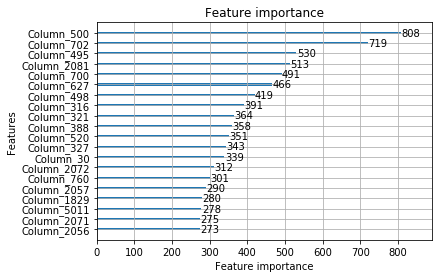

Fold :2
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.955986	training's binary_logloss: 0.237349	valid_1's auc: 0.957326	valid_1's binary_logloss: 0.235521
[200]	training's auc: 0.959851	training's binary_logloss: 0.190588	valid_1's auc: 0.96024	valid_1's binary_logloss: 0.189729
[300]	training's auc: 0.963466	training's binary_logloss: 0.178573	valid_1's auc: 0.962412	valid_1's binary_logloss: 0.17996
[400]	training's auc: 0.96674	training's binary_logloss: 0.170763	valid_1's auc: 0.963681	valid_1's binary_logloss: 0.175435
[500]	training's auc: 0.969595	training's binary_logloss: 0.164754	valid_1's auc: 0.964552	valid_1's binary_logloss: 0.172914
[600]	training's auc: 0.971965	training's binary_logloss: 0.159905	valid_1's auc: 0.965005	valid_1's binary_logloss: 0.171514
[700]	training's auc: 0.974142	training's binary_logloss: 0.155427	valid_1's auc: 0.965321	valid_1's binary_logloss: 0.170502
[800]	training's auc: 0.976012	training's binary_log

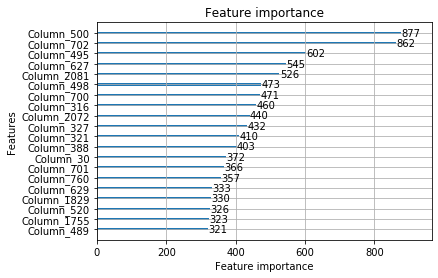

Fold :3
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.956017	training's binary_logloss: 0.236165	valid_1's auc: 0.954451	valid_1's binary_logloss: 0.237619
[200]	training's auc: 0.959752	training's binary_logloss: 0.190054	valid_1's auc: 0.958016	valid_1's binary_logloss: 0.192861
[300]	training's auc: 0.963561	training's binary_logloss: 0.177548	valid_1's auc: 0.960633	valid_1's binary_logloss: 0.182676
[400]	training's auc: 0.967176	training's binary_logloss: 0.169533	valid_1's auc: 0.962377	valid_1's binary_logloss: 0.177982
[500]	training's auc: 0.970001	training's binary_logloss: 0.163705	valid_1's auc: 0.963193	valid_1's binary_logloss: 0.175752
[600]	training's auc: 0.972425	training's binary_logloss: 0.158761	valid_1's auc: 0.963696	valid_1's binary_logloss: 0.174332
[700]	training's auc: 0.974485	training's binary_logloss: 0.15453	valid_1's auc: 0.963904	valid_1's binary_logloss: 0.173705
[800]	training's auc: 0.976386	training's binary_l

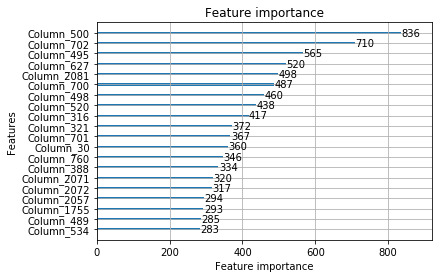

Fold :4
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.956445	training's binary_logloss: 0.236486	valid_1's auc: 0.956515	valid_1's binary_logloss: 0.237348
[200]	training's auc: 0.960104	training's binary_logloss: 0.189701	valid_1's auc: 0.95964	valid_1's binary_logloss: 0.191546
[300]	training's auc: 0.96352	training's binary_logloss: 0.177707	valid_1's auc: 0.961861	valid_1's binary_logloss: 0.18135
[400]	training's auc: 0.966882	training's binary_logloss: 0.170148	valid_1's auc: 0.963278	valid_1's binary_logloss: 0.176953
[500]	training's auc: 0.969907	training's binary_logloss: 0.16403	valid_1's auc: 0.964084	valid_1's binary_logloss: 0.174565
[600]	training's auc: 0.972292	training's binary_logloss: 0.159185	valid_1's auc: 0.964483	valid_1's binary_logloss: 0.173272
[700]	training's auc: 0.974386	training's binary_logloss: 0.154797	valid_1's auc: 0.964837	valid_1's binary_logloss: 0.172182
[800]	training's auc: 0.976303	training's binary_logl

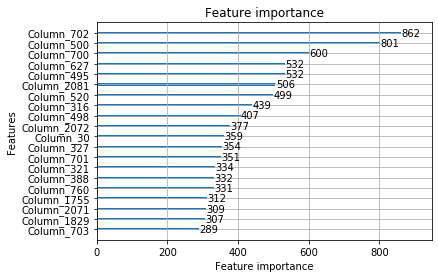

In [63]:
scores = []
for i,(tr_idx, val_idx) in enumerate(kf.split(X_ohe,y)):
    print('Fold :{}'.format(i))
    tr_X = X_ohe[tr_idx]  # training for this loop
    tr_y = y[tr_idx] #
    val_X = X_ohe[val_idx]# validation data for this loop
    val_y = y[val_idx]
    # here build your models
    model = model_lgb
    model.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (val_X, val_y)], eval_metric = 'auc', verbose=100, early_stopping_rounds= 50)
    #picking best model?
    pred_val_y = model.predict_proba(val_X,num_iteration=model.best_iteration_)[:,1]
    #y_pred = model.predict(val_X)
    #measuring model vs validation
    score = roc_auc_score(val_y,pred_val_y)
    scores.append(score)
    print('current performance by auc:{}'.format(score))
    lightgbm.plot_importance(model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance', ylabel='Features', importance_type='split', max_num_features=20, ignore_zero=True, figsize=None, grid=True, precision=3)
    plt.show()
    #could use plt.savefig to save them